In [1]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import (
    SentenceTransformersDocumentEmbedder,
    SentenceTransformersTextEmbedder,
)
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

# Preparation Instructions
1. `uv sync` or `pip install -r requirements.txt`
2. copy .env.example to .env and add your API keys for OpenAI
3. Run the notebook :)

In [2]:
import sys

sys.path.append("..")

In [3]:
from src.utils import create_document_embedding_visualization, display_pipeline

# Indexing Pipeline

## Read Documents

In [4]:
import os

# all pdf files in the data folder
docs = [f"data/raw/{file}" for file in os.listdir("data/raw") if file.endswith(".pdf")]

In [5]:
indexing_pipeline = Pipeline()

In [6]:
from haystack.components.converters import PyPDFToDocument

pdf_loader = PyPDFToDocument()
indexing_pipeline.add_component("pdf_converter", pdf_loader)

In [7]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    pdf_converter["pdf_converter<br><small><i>PyPDFToDocument</i></small>"]
```

In [8]:
res = indexing_pipeline.run({"pdf_converter": {"sources": docs}})

## Split Documents

In [9]:
from haystack.components.preprocessors import DocumentSplitter

splitter = DocumentSplitter(split_by="sentence", split_length=4, split_overlap=1)
indexing_pipeline.add_component("splitter", splitter)

In [10]:
# TODO: Add Tracing, HPs, pip install

In [11]:
indexing_pipeline.connect("pdf_converter", "splitter")

🚅 Components
  - pdf_converter: PyPDFToDocument
  - splitter: DocumentSplitter
🛤️ Connections
  - pdf_converter.documents -> splitter.documents (List[Document])

In [12]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    pdf_converter["pdf_converter<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    pdf_converter ==> splitter
```

In [13]:
res = indexing_pipeline.run({"pdf_converter": {"sources": docs}})

No abbreviations file found for en. Using default abbreviations.


## Embed Chunks

In [14]:
embed_model = "sentence-transformers/all-MiniLM-L6-v2"

In [15]:
doc_embedder = SentenceTransformersDocumentEmbedder(model=embed_model, batch_size=16)
indexing_pipeline.add_component("doc_embedder", doc_embedder)

In [16]:
indexing_pipeline.connect("splitter", "doc_embedder")

🚅 Components
  - pdf_converter: PyPDFToDocument
  - splitter: DocumentSplitter
  - doc_embedder: SentenceTransformersDocumentEmbedder
🛤️ Connections
  - pdf_converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])

In [17]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    pdf_converter["pdf_converter<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    doc_embedder["doc_embedder<br><small><i>SentenceTransformersDocumentEmbedder</i></small>"]
    pdf_converter ==> splitter
    splitter ==> doc_embedder
```

In [18]:
indexing_pipeline.warm_up()

In [19]:
res = indexing_pipeline.run(
    {"pdf_converter": {"sources": docs}}, include_outputs_from={"doc_embedder"}
)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
res["doc_embedder"]["documents"][0].embedding[:10]

[-0.10664563626050949,
 -0.0008424795232713223,
 0.014466284774243832,
 0.012633265927433968,
 -0.06408296525478363,
 0.05076011270284653,
 -0.006638782098889351,
 -0.02632042020559311,
 0.005767115391790867,
 -0.034158192574977875]

In [21]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "FALSE"  # This avoids a warning

## Visualize Embeddings

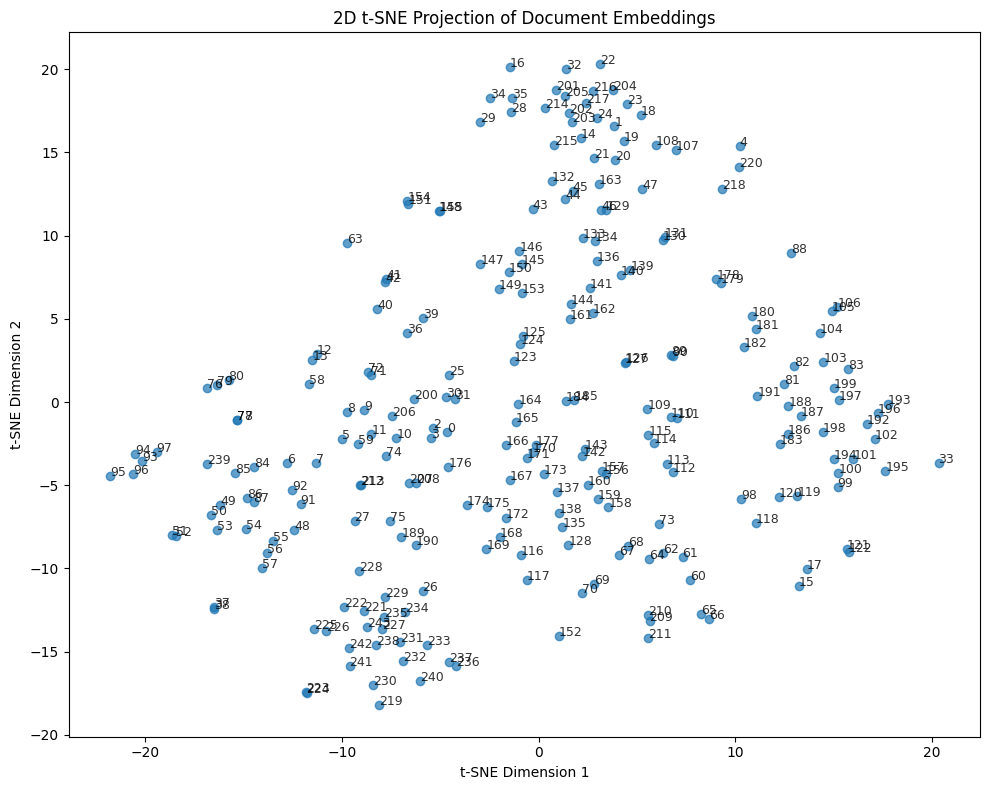

In [22]:
# Get the embedded documents from the previous run
embedded_documents = res["doc_embedder"]["documents"]

# Create the visualization
projection = create_document_embedding_visualization(embedded_documents)

## Write Chunks to Document Store

In [23]:
document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store, policy=DuplicatePolicy.OVERWRITE)

In [24]:
indexing_pipeline.add_component("document_writer", document_writer)
indexing_pipeline.connect("doc_embedder", "document_writer")

🚅 Components
  - pdf_converter: PyPDFToDocument
  - splitter: DocumentSplitter
  - doc_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - pdf_converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> doc_embedder.documents (List[Document])
  - doc_embedder.documents -> document_writer.documents (List[Document])

In [25]:
display_pipeline(indexing_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    pdf_converter["pdf_converter<br><small><i>PyPDFToDocument</i></small>"]
    splitter["splitter<br><small><i>DocumentSplitter</i></small>"]
    doc_embedder["doc_embedder<br><small><i>SentenceTransformersDocumentEmbedder</i></small>"]
    document_writer["document_writer<br><small><i>DocumentWriter</i></small>"]
    pdf_converter ==> splitter
    splitter ==> doc_embedder
    doc_embedder ==> document_writer
```

In [26]:
indexing_pipeline.run({"pdf_converter": {"sources": docs}})

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 244}}

# Retrieval + Generation Pipeline


In [27]:
rag_pipeline = Pipeline()

## Embed Query


In [28]:
query_embedder = SentenceTransformersTextEmbedder(model=embed_model)

In [29]:
rag_pipeline.add_component("query_embedder", query_embedder)

In [30]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
```

## Define Retriever


In [31]:
retriever = InMemoryEmbeddingRetriever(document_store, top_k=10)

In [32]:
rag_pipeline.add_component("retriever", retriever)

In [33]:
rag_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

In [34]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
    retriever["retriever<br><small><i>InMemoryEmbeddingRetriever</i></small>"]
    query_embedder ==> retriever
```

## LLM Generation

In [35]:
generator = OpenAIGenerator(model="gpt-4o-mini")

In [36]:
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    This is the metadata of the document:
    {{ document.meta }}
    ================================
    This is the content of the document:
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

In [37]:
prompt_builder = PromptBuilder(template=template)

In [38]:
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

In [39]:
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [40]:
display_pipeline(rag_pipeline)

```mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'fontSize': '16px', 'fontFamily': 'arial', 'lineWidth': '2px' }}}%%
graph TD;
    query_embedder["query_embedder<br><small><i>SentenceTransformersTextEmbedder</i></small>"]
    retriever["retriever<br><small><i>InMemoryEmbeddingRetriever</i></small>"]
    prompt_builder["prompt_builder<br><small><i>PromptBuilder</i></small>"]
    llm["llm<br><small><i>OpenAIGenerator</i></small>"]
    query_embedder ==> retriever
    retriever ==> prompt_builder
    prompt_builder ==> llm
```

# Query Pipeline

In [41]:
question = "What is modular RAG? in 2 sentences"

response = rag_pipeline.run(
    {"query_embedder": {"text": question}, "prompt_builder": {"question": question}},
    include_outputs_from=["retriever"],
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
llm_response = response["llm"]["replies"][0]

In [44]:
from src.utils import nicer_print

nicer_print(llm_response, width=100)

Modular RAG is an innovative paradigm that breaks down the complex architecture of RAG systems into
well-defined, discrete functional modules, each characterized by specific operational functions.
This modular approach enhances scalability, flexibility, and compatibility with new methods,
allowing for a more dynamic and efficient framework for retrieval and generation tasks.


## Analyze Results

In [45]:
retrieved_documents = response["retriever"]["documents"]

In [46]:
retrieved_documents[0].score

0.7471378992391138